In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'Baseline'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.horizontal_and_vertical_flip_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(495000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.baseline(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 128)            114816    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 128)            82048     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 128)            114816    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 128)            82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 128)            0     

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/436 [..............................] - ETA: 1:30:47 - loss: 8.4840

  4/436 [..............................] - ETA: 8s - loss: 8.3616     

  7/436 [..............................] - ETA: 7s - loss: 8.3050

 10/436 [..............................] - ETA: 7s - loss: 8.2640

 13/436 [..............................] - ETA: 7s - loss: 8.2371

 16/436 [>.............................] - ETA: 7s - loss: 8.2138

 19/436 [>.............................] - ETA: 7s - loss: 8.2071

 22/436 [>.............................] - ETA: 7s - loss: 8.2144

 25/436 [>.............................] - ETA: 7s - loss: 8.2244

 28/436 [>.............................] - ETA: 7s - loss: 8.2324

 31/436 [=>............................] - ETA: 7s - loss: 8.2296

 34/436 [=>............................] - ETA: 7s - loss: 8.2180

 37/436 [=>............................] - ETA: 7s - loss: 8.2013

 40/436 [=>............................] - ETA: 7s - loss: 8.1834

 43/436 [=>............................] - ETA: 7s - loss: 8.1640

 46/436 [==>...........................] - ETA: 7s - loss: 8.1450

 49/436 [==>...........................] - ETA: 7s - loss: 8.1263

 52/436 [==>...........................] - ETA: 7s - loss: 8.1077

 55/436 [==>...........................] - ETA: 7s - loss: 8.0903

 58/436 [==>...........................] - ETA: 6s - loss: 8.0728

 61/436 [===>..........................] - ETA: 6s - loss: 8.0560

 64/436 [===>..........................] - ETA: 6s - loss: 8.0421

 67/436 [===>..........................] - ETA: 6s - loss: 8.0314

 70/436 [===>..........................] - ETA: 6s - loss: 8.0239

 73/436 [====>.........................] - ETA: 6s - loss: 8.0189

 76/436 [====>.........................] - ETA: 6s - loss: 8.0161

 79/436 [====>.........................] - ETA: 6s - loss: 8.0150

 82/436 [====>.........................] - ETA: 6s - loss: 8.0150

 85/436 [====>.........................] - ETA: 6s - loss: 8.0159

 88/436 [=====>........................] - ETA: 6s - loss: 8.0176

 91/436 [=====>........................] - ETA: 6s - loss: 8.0200

 94/436 [=====>........................] - ETA: 6s - loss: 8.0229

 97/436 [=====>........................] - ETA: 6s - loss: 8.0260

100/436 [=====>........................] - ETA: 6s - loss: 8.0297

103/436 [======>.......................] - ETA: 6s - loss: 8.0339

106/436 [======>.......................] - ETA: 6s - loss: 8.0383

110/436 [======>.......................] - ETA: 5s - loss: 8.0446

114/436 [======>.......................] - ETA: 5s - loss: 8.0512

118/436 [=======>......................] - ETA: 5s - loss: 8.0581

122/436 [=======>......................] - ETA: 5s - loss: 8.0650

126/436 [=======>......................] - ETA: 5s - loss: 8.0719

130/436 [=======>......................] - ETA: 5s - loss: 8.0790

134/436 [========>.....................] - ETA: 5s - loss: 8.0860



138/436 [========>.....................] - ETA: 5s - loss: 8.0930

142/436 [========>.....................] - ETA: 5s - loss: 8.0999

146/436 [=========>....................] - ETA: 5s - loss: 8.1068

150/436 [=========>....................] - ETA: 5s - loss: 8.1136

154/436 [=========>....................] - ETA: 4s - loss: 8.1204

158/436 [=========>....................] - ETA: 4s - loss: 8.1270

162/436 [==========>...................] - ETA: 4s - loss: 8.1336

165/436 [==========>...................] - ETA: 4s - loss: 8.1383



169/436 [==========>...................] - ETA: 4s - loss: 8.1445

173/436 [==========>...................] - ETA: 4s - loss: 8.1507

177/436 [===========>..................] - ETA: 4s - loss: 8.1568

181/436 [===========>..................] - ETA: 4s - loss: 8.1629

185/436 [===========>..................] - ETA: 4s - loss: 8.1691

188/436 [===========>..................] - ETA: 4s - loss: 8.1736

192/436 [============>.................] - ETA: 4s - loss: 8.1796



196/436 [============>.................] - ETA: 4s - loss: 8.1854

200/436 [============>.................] - ETA: 4s - loss: 8.1912

204/436 [=============>................] - ETA: 4s - loss: 8.1969

207/436 [=============>................] - ETA: 3s - loss: 8.2011

211/436 [=============>................] - ETA: 3s - loss: 8.2066

215/436 [=============>................] - ETA: 3s - loss: 8.2120

219/436 [==============>...............] - ETA: 3s - loss: 8.2174



223/436 [==============>...............] - ETA: 3s - loss: 8.2227

227/436 [==============>...............] - ETA: 3s - loss: 8.2278

231/436 [==============>...............] - ETA: 3s - loss: 8.2329

235/436 [===============>..............] - ETA: 3s - loss: 8.2379

239/436 [===============>..............] - ETA: 3s - loss: 8.2429

243/436 [===============>..............] - ETA: 3s - loss: 8.2477

247/436 [===============>..............] - ETA: 3s - loss: 8.2525

251/436 [================>.............] - ETA: 3s - loss: 8.2571

255/436 [================>.............] - ETA: 3s - loss: 8.2616

259/436 [================>.............] - ETA: 3s - loss: 8.2662

263/436 [=================>............] - ETA: 2s - loss: 8.2706

267/436 [=================>............] - ETA: 2s - loss: 8.2750



271/436 [=================>............] - ETA: 2s - loss: 8.2793

275/436 [=================>............] - ETA: 2s - loss: 8.2835

279/436 [==================>...........] - ETA: 2s - loss: 8.2877

283/436 [==================>...........] - ETA: 2s - loss: 8.2918

287/436 [==================>...........] - ETA: 2s - loss: 8.2958

291/436 [===================>..........] - ETA: 2s - loss: 8.2998

295/436 [===================>..........] - ETA: 2s - loss: 8.3037



299/436 [===================>..........] - ETA: 2s - loss: 8.3075

303/436 [===================>..........] - ETA: 2s - loss: 8.3112

306/436 [====================>.........] - ETA: 2s - loss: 8.3140



310/436 [====================>.........] - ETA: 2s - loss: 8.3176

314/436 [====================>.........] - ETA: 2s - loss: 8.3213



318/436 [====================>.........] - ETA: 1s - loss: 8.3248



322/436 [=====================>........] - ETA: 1s - loss: 8.3283



326/436 [=====================>........] - ETA: 1s - loss: 8.3317



330/436 [=====================>........] - ETA: 1s - loss: 8.3351

333/436 [=====================>........] - ETA: 1s - loss: 8.3376

337/436 [======================>.......] - ETA: 1s - loss: 8.3409

341/436 [======================>.......] - ETA: 1s - loss: 8.3441

345/436 [======================>.......] - ETA: 1s - loss: 8.3473

348/436 [======================>.......] - ETA: 1s - loss: 8.3496

351/436 [=======================>......] - ETA: 1s - loss: 8.3520

354/436 [=======================>......] - ETA: 1s - loss: 8.3543

357/436 [=======================>......] - ETA: 1s - loss: 8.3565

360/436 [=======================>......] - ETA: 1s - loss: 8.3588

363/436 [=======================>......] - ETA: 1s - loss: 8.3610

367/436 [========================>.....] - ETA: 1s - loss: 8.3639

371/436 [========================>.....] - ETA: 1s - loss: 8.3668

375/436 [========================>.....] - ETA: 1s - loss: 8.3696

379/436 [=========================>....] - ETA: 0s - loss: 8.3724

383/436 [=========================>....] - ETA: 0s - loss: 8.3751



387/436 [=========================>....] - ETA: 0s - loss: 8.3778

390/436 [=========================>....] - ETA: 0s - loss: 8.3798

394/436 [==========================>...] - ETA: 0s - loss: 8.3824

398/436 [==========================>...] - ETA: 0s - loss: 8.3850

402/436 [==========================>...] - ETA: 0s - loss: 8.3876

406/436 [==========================>...] - ETA: 0s - loss: 8.3901

410/436 [===========================>..] - ETA: 0s - loss: 8.3925

414/436 [===========================>..] - ETA: 0s - loss: 8.3950

418/436 [===========================>..] - ETA: 0s - loss: 8.3974

422/436 [============================>.] - ETA: 0s - loss: 8.3998

426/436 [============================>.] - ETA: 0s - loss: 8.4021

430/436 [============================>.] - ETA: 0s - loss: 8.4045

434/436 [============================>.] - ETA: 0s - loss: 8.4068

436/436 [==============================] - ETA: 0s - loss: 8.4079

436/436 [==============================] - 21s 19ms/step - loss: 8.4084 - val_loss: 8.7904


Epoch 2/100
  1/436 [..............................] - ETA: 7s - loss: 8.5627

  4/436 [..............................] - ETA: 7s - loss: 8.6896

  8/436 [..............................] - ETA: 6s - loss: 8.7671

 12/436 [..............................] - ETA: 6s - loss: 8.7861

 16/436 [>.............................] - ETA: 6s - loss: 8.7910

 19/436 [>.............................] - ETA: 6s - loss: 8.7905

 23/436 [>.............................] - ETA: 6s - loss: 8.7922

 27/436 [>.............................] - ETA: 6s - loss: 8.7951

 30/436 [=>............................] - ETA: 6s - loss: 8.7950

 34/436 [=>............................] - ETA: 6s - loss: 8.7963

 38/436 [=>............................] - ETA: 6s - loss: 8.7969

 41/436 [=>............................] - ETA: 6s - loss: 8.7977

 44/436 [==>...........................] - ETA: 6s - loss: 8.7981

 47/436 [==>...........................] - ETA: 6s - loss: 8.7989



 50/436 [==>...........................] - ETA: 6s - loss: 8.7992

 53/436 [==>...........................] - ETA: 6s - loss: 8.7999

 56/436 [==>...........................] - ETA: 6s - loss: 8.8009

 60/436 [===>..........................] - ETA: 6s - loss: 8.8027

 63/436 [===>..........................] - ETA: 6s - loss: 8.8043

 67/436 [===>..........................] - ETA: 6s - loss: 8.8062

 71/436 [===>..........................] - ETA: 6s - loss: 8.8076

 75/436 [====>.........................] - ETA: 5s - loss: 8.8088

 78/436 [====>.........................] - ETA: 5s - loss: 8.8099

 82/436 [====>.........................] - ETA: 5s - loss: 8.8114

 85/436 [====>.........................] - ETA: 5s - loss: 8.8125

 89/436 [=====>........................] - ETA: 5s - loss: 8.8139

 92/436 [=====>........................] - ETA: 5s - loss: 8.8148

 96/436 [=====>........................] - ETA: 5s - loss: 8.8159

 99/436 [=====>........................] - ETA: 5s - loss: 8.8164

103/436 [======>.......................] - ETA: 5s - loss: 8.8171

106/436 [======>.......................] - ETA: 5s - loss: 8.8175

109/436 [======>.......................] - ETA: 5s - loss: 8.8180

113/436 [======>.......................] - ETA: 5s - loss: 8.8186

117/436 [=======>......................] - ETA: 5s - loss: 8.8192

121/436 [=======>......................] - ETA: 5s - loss: 8.8197

125/436 [=======>......................] - ETA: 5s - loss: 8.8202

129/436 [=======>......................] - ETA: 5s - loss: 8.8208

133/436 [========>.....................] - ETA: 5s - loss: 8.8214



137/436 [========>.....................] - ETA: 4s - loss: 8.8218

140/436 [========>.....................] - ETA: 4s - loss: 8.8220

143/436 [========>.....................] - ETA: 4s - loss: 8.8222

146/436 [=========>....................] - ETA: 4s - loss: 8.8224

149/436 [=========>....................] - ETA: 4s - loss: 8.8224

153/436 [=========>....................] - ETA: 4s - loss: 8.8225



157/436 [=========>....................] - ETA: 4s - loss: 8.8225

161/436 [==========>...................] - ETA: 4s - loss: 8.8225



164/436 [==========>...................] - ETA: 4s - loss: 8.8226

168/436 [==========>...................] - ETA: 4s - loss: 8.8227

172/436 [==========>...................] - ETA: 4s - loss: 8.8228

176/436 [===========>..................] - ETA: 4s - loss: 8.8229

180/436 [===========>..................] - ETA: 4s - loss: 8.8230



184/436 [===========>..................] - ETA: 4s - loss: 8.8231

188/436 [===========>..................] - ETA: 4s - loss: 8.8233



192/436 [============>.................] - ETA: 4s - loss: 8.8234



196/436 [============>.................] - ETA: 3s - loss: 8.8235

200/436 [============>.................] - ETA: 3s - loss: 8.8235



204/436 [=============>................] - ETA: 3s - loss: 8.8234

208/436 [=============>................] - ETA: 3s - loss: 8.8233

212/436 [=============>................] - ETA: 3s - loss: 8.8233

216/436 [=============>................] - ETA: 3s - loss: 8.8232

220/436 [==============>...............] - ETA: 3s - loss: 8.8233



224/436 [==============>...............] - ETA: 3s - loss: 8.8234

228/436 [==============>...............] - ETA: 3s - loss: 8.8235

231/436 [==============>...............] - ETA: 3s - loss: 8.8235

235/436 [===============>..............] - ETA: 3s - loss: 8.8237

239/436 [===============>..............] - ETA: 3s - loss: 8.8238

243/436 [===============>..............] - ETA: 3s - loss: 8.8240



247/436 [===============>..............] - ETA: 3s - loss: 8.8242

250/436 [================>.............] - ETA: 3s - loss: 8.8243

254/436 [================>.............] - ETA: 2s - loss: 8.8244

258/436 [================>.............] - ETA: 2s - loss: 8.8245

261/436 [================>.............] - ETA: 2s - loss: 8.8245

264/436 [=================>............] - ETA: 2s - loss: 8.8246

267/436 [=================>............] - ETA: 2s - loss: 8.8246

271/436 [=================>............] - ETA: 2s - loss: 8.8246

275/436 [=================>............] - ETA: 2s - loss: 8.8246

279/436 [==================>...........] - ETA: 2s - loss: 8.8246

282/436 [==================>...........] - ETA: 2s - loss: 8.8246

286/436 [==================>...........] - ETA: 2s - loss: 8.8246



290/436 [==================>...........] - ETA: 2s - loss: 8.8247

293/436 [===================>..........] - ETA: 2s - loss: 8.8247

296/436 [===================>..........] - ETA: 2s - loss: 8.8247

300/436 [===================>..........] - ETA: 2s - loss: 8.8247

304/436 [===================>..........] - ETA: 2s - loss: 8.8246

308/436 [====================>.........]

 - ETA: 2s - loss: 8.8246

311/436 [====================>.........] - ETA: 2s - loss: 8.8246

315/436 [====================>.........] - ETA: 1s - loss: 8.8245

319/436 [====================>.........] - ETA: 1s - loss: 8.8245



323/436 [=====================>........] - ETA: 1s - loss: 8.8244

327/436 [=====================>........] - ETA: 1s - loss: 8.8243

331/436 [=====================>........] - ETA: 1s - loss: 8.8242

335/436 [======================>.......] - ETA: 1s - loss: 8.8241

339/436 [======================>.......] - ETA: 1s - loss: 8.8240

343/436 [======================>.......] - ETA: 1s - loss: 8.8239

347/436 [======================>.......] - ETA: 1s - loss: 8.8239

351/436 [=======================>......] - ETA: 1s - loss: 8.8238



355/436 [=======================>......] - ETA: 1s - loss: 8.8236

359/436 [=======================>......] - ETA: 1s - loss: 8.8235

363/436 [=======================>......] - ETA: 1s - loss: 8.8234

366/436 [========================>.....] - ETA: 1s - loss: 8.8233

370/436 [========================>.....] - ETA: 1s - loss: 8.8231

373/436 [========================>.....] - ETA: 1s - loss: 8.8230

377/436 [========================>.....] - ETA: 0s - loss: 8.8229



381/436 [=========================>....] - ETA: 0s - loss: 8.8228

385/436 [=========================>....] - ETA: 0s - loss: 8.8226

389/436 [=========================>....] - ETA: 0s - loss: 8.8225

393/436 [==========================>...] - ETA: 0s - loss: 8.8223

396/436 [==========================>...] - ETA: 0s - loss: 8.8222

400/436 [==========================>...] - ETA: 0s - loss: 8.8221

404/436 [==========================>...] - ETA: 0s - loss: 8.8219

408/436 [===========================>..] - ETA: 0s - loss: 8.8218



412/436 [===========================>..] - ETA: 0s - loss: 8.8216

416/436 [===========================>..] - ETA: 0s - loss: 8.8214



420/436 [===========================>..] - ETA: 0s - loss: 8.8212

424/436 [============================>.] - ETA: 0s - loss: 8.8210

428/436 [============================>.] - ETA: 0s - loss: 8.8209

432/436 [============================>.] - ETA: 0s - loss: 8.8207

436/436 [==============================] - ETA: 0s - loss: 8.8205

436/436 [==============================] - 7s 17ms/step - loss: 8.8204 - val_loss: 8.7904


Epoch 3/100
  1/436 [..............................] - ETA: 7s - loss: 8.6257

  5/436 [..............................] - ETA: 7s - loss: 8.7750

  9/436 [..............................] - ETA: 6s - loss: 8.7907

 13/436 [..............................] - ETA: 6s - loss: 8.7907

 17/436 [>.............................] - ETA: 6s - loss: 8.7942

 21/436 [>.............................] - ETA: 6s - loss: 8.7898



 25/436 [>.............................] - ETA: 6s - loss: 8.7859

 29/436 [>.............................] - ETA: 6s - loss: 8.7846



 33/436 [=>............................] - ETA: 6s - loss: 8.7837



 37/436 [=>............................] - ETA: 6s - loss: 8.7820

 40/436 [=>............................] - ETA: 6s - loss: 8.7814

 44/436 [==>...........................] - ETA: 6s - loss: 8.7808

 48/436 [==>...........................] - ETA: 6s - loss: 8.7812

 52/436 [==>...........................] - ETA: 6s - loss: 8.7818



 56/436 [==>...........................] - ETA: 6s - loss: 8.7821



 60/436 [===>..........................] - ETA: 6s - loss: 8.7832

 64/436 [===>..........................] - ETA: 5s - loss: 8.7838

 68/436 [===>..........................] - ETA: 5s - loss: 8.7839

 72/436 [===>..........................] - ETA: 5s - loss: 8.7839

 76/436 [====>.........................] - ETA: 5s - loss: 8.7842



 80/436 [====>.........................] - ETA: 5s - loss: 8.7850



 84/436 [====>.........................] - ETA: 5s - loss: 8.7862

 87/436 [====>.........................] - ETA: 5s - loss: 8.7874

 91/436 [=====>........................] - ETA: 5s - loss: 8.7887

 95/436 [=====>........................] - ETA: 5s - loss: 8.7899

 98/436 [=====>........................] - ETA: 5s - loss: 8.7907

102/436 [======>.......................] - ETA: 5s - loss: 8.7917

106/436 [======>.......................] - ETA: 5s - loss: 8.7927

110/436 [======>.......................] - ETA: 5s - loss: 8.7937

114/436 [======>.......................] - ETA: 5s - loss: 8.7947

118/436 [=======>......................] - ETA: 5s - loss: 8.7956

122/436 [=======>......................] - ETA: 5s - loss: 8.7966

126/436 [=======>......................] - ETA: 4s - loss: 8.7975



130/436 [=======>......................] - ETA: 4s - loss: 8.7983

134/436 [========>.....................] - ETA: 4s - loss: 8.7991

138/436 [========>.....................] - ETA: 4s - loss: 8.7999

141/436 [========>.....................] - ETA: 4s - loss: 8.8005

144/436 [========>.....................] - ETA: 4s - loss: 8.8011

148/436 [=========>....................] - ETA: 4s - loss: 8.8018

152/436 [=========>....................] - ETA: 4s - loss: 8.8024

156/436 [=========>....................] - ETA: 4s - loss: 8.8030

160/436 [==========>...................] - ETA: 4s - loss: 8.8034

163/436 [==========>...................] - ETA: 4s - loss: 8.8037

167/436 [==========>...................] - ETA: 4s - loss: 8.8040

171/436 [==========>...................] - ETA: 4s - loss: 8.8042

175/436 [===========>..................] - ETA: 4s - loss: 8.8045

179/436 [===========>..................] - ETA: 4s - loss: 8.8048



183/436 [===========>..................] - ETA: 4s - loss: 8.8049

186/436 [===========>..................] - ETA: 4s - loss: 8.8050

190/436 [============>.................] - ETA: 3s - loss: 8.8051

194/436 [============>.................] - ETA: 3s - loss: 8.8052

198/436 [============>.................] - ETA: 3s - loss: 8.8055

202/436 [============>.................] - ETA: 3s - loss: 8.8057

206/436 [=============>................] - ETA: 3s - loss: 8.8059

210/436 [=============>................] - ETA: 3s - loss: 8.8060

214/436 [=============>................] - ETA: 3s - loss: 8.8061

218/436 [==============>...............] - ETA: 3s - loss: 8.8061

222/436 [==============>...............] - ETA: 3s - loss: 8.8060

226/436 [==============>...............] - ETA: 3s - loss: 8.8059

230/436 [==============>...............] - ETA: 3s - loss: 8.8059

234/436 [===============>..............] - ETA: 3s - loss: 8.8059

238/436 [===============>..............] - ETA: 3s - loss: 8.8059



242/436 [===============>..............] - ETA: 3s - loss: 8.8058

246/436 [===============>..............] - ETA: 3s - loss: 8.8058

249/436 [================>.............] - ETA: 3s - loss: 8.8058

253/436 [================>.............] - ETA: 2s - loss: 8.8058

257/436 [================>.............] - ETA: 2s - loss: 8.8057

261/436 [================>.............] - ETA: 2s - loss: 8.8055

265/436 [=================>............] - ETA: 2s - loss: 8.8054

269/436 [=================>............] - ETA: 2s - loss: 8.8053

273/436 [=================>............] - ETA: 2s - loss: 8.8051

277/436 [==================>...........] - ETA: 2s - loss: 8.8049

281/436 [==================>...........] - ETA: 2s - loss: 8.8048



285/436 [==================>...........] - ETA: 2s - loss: 8.8046

289/436 [==================>...........] - ETA: 2s - loss: 8.8045

293/436 [===================>..........] - ETA: 2s - loss: 8.8044

297/436 [===================>..........] - ETA: 2s - loss: 8.8043

301/436 [===================>..........] - ETA: 2s - loss: 8.8041

305/436 [===================>..........] - ETA: 2s - loss: 8.8040

309/436 [====================>.........] - ETA: 2s - loss: 8.8038

313/436 [====================>.........] - ETA: 1s - loss: 8.8036

316/436 [====================>.........] - ETA: 1s - loss: 8.8035

320/436 [=====================>........] - ETA: 1s - loss: 8.8034

324/436 [=====================>........] - ETA: 1s - loss: 8.8032

328/436 [=====================>........] - ETA: 1s - loss: 8.8030

332/436 [=====================>........] - ETA: 1s - loss: 8.8029

336/436 [======================>.......] - ETA: 1s - loss: 8.8027

340/436 [======================>.......] - ETA: 1s - loss: 8.8025

344/436 [======================>.......] - ETA: 1s - loss: 8.8024

348/436 [======================>.......] - ETA: 1s - loss: 8.8023

352/436 [=======================>......] - ETA: 1s - loss: 8.8021

356/436 [=======================>......] - ETA: 1s - loss: 8.8020

360/436 [=======================>......] - ETA: 1s - loss: 8.8019

364/436 [========================>.....] - ETA: 1s - loss: 8.8019

368/436 [========================>.....] - ETA: 1s - loss: 8.8018

372/436 [========================>.....] - ETA: 1s - loss: 8.8017

376/436 [========================>.....] - ETA: 0s - loss: 8.8017

380/436 [=========================>....] - ETA: 0s - loss: 8.8016

384/436 [=========================>....] - ETA: 0s - loss: 8.8016

388/436 [=========================>....] - ETA: 0s - loss: 8.8015

392/436 [=========================>....] - ETA: 0s - loss: 8.8014



396/436 [==========================>...] - ETA: 0s - loss: 8.8014

400/436 [==========================>...] - ETA: 0s - loss: 8.8013

404/436 [==========================>...] - ETA: 0s - loss: 8.8013

408/436 [===========================>..] - ETA: 0s - loss: 8.8012

411/436 [===========================>..] - ETA: 0s - loss: 8.8012

415/436 [===========================>..] - ETA: 0s - loss: 8.8011

419/436 [===========================>..] - ETA: 0s - loss: 8.8011

423/436 [============================>.] - ETA: 0s - loss: 8.8011

427/436 [============================>.] - ETA: 0s - loss: 8.8010

431/436 [============================>.] - ETA: 0s - loss: 8.8010



435/436 [============================>.] - ETA: 0s - loss: 8.8010

436/436 [==============================] - 7s 17ms/step - loss: 8.8010 - val_loss: 8.7904


Epoch 4/100
  1/436 [..............................] - ETA: 6s - loss: 9.3812

  5/436 [..............................] - ETA: 7s - loss: 9.0875

  9/436 [..............................] - ETA: 6s - loss: 8.9571

 13/436 [..............................] - ETA: 6s - loss: 8.8982

 17/436 [>.............................] - ETA: 6s - loss: 8.8694

 21/436 [>.............................] - ETA: 6s - loss: 8.8547

 25/436 [>.............................] - ETA: 6s - loss: 8.8464

 29/436 [>.............................] - ETA: 6s - loss: 8.8419

 33/436 [=>............................] - ETA: 6s - loss: 8.8426

 37/436 [=>............................] - ETA: 6s - loss: 8.8438

 41/436 [=>............................] - ETA: 6s - loss: 8.8428

 45/436 [==>...........................] - ETA: 6s - loss: 8.8420

 49/436 [==>...........................] - ETA: 6s - loss: 8.8412

 53/436 [==>...........................] - ETA: 6s - loss: 8.8403

 57/436 [==>...........................] - ETA: 6s - loss: 8.8391

 61/436 [===>..........................] - ETA: 5s - loss: 8.8385

 65/436 [===>..........................] - ETA: 5s - loss: 8.8379

 69/436 [===>..........................] - ETA: 5s - loss: 8.8378

 73/436 [====>.........................] - ETA: 5s - loss: 8.8371

 77/436 [====>.........................] - ETA: 5s - loss: 8.8366

 81/436 [====>.........................] - ETA: 5s - loss: 8.8361

 85/436 [====>.........................] - ETA: 5s - loss: 8.8356

 89/436 [=====>........................] - ETA: 5s - loss: 8.8350

 93/436 [=====>........................] - ETA: 5s - loss: 8.8348

 97/436 [=====>........................] - ETA: 5s - loss: 8.8344

101/436 [=====>........................] - ETA: 5s - loss: 8.8339

105/436 [======>.......................] - ETA: 5s - loss: 8.8333

109/436 [======>.......................] - ETA: 5s - loss: 8.8330



113/436 [======>.......................] - ETA: 5s - loss: 8.8328

117/436 [=======>......................] - ETA: 5s - loss: 8.8324

121/436 [=======>......................] - ETA: 5s - loss: 8.8319

125/436 [=======>......................] - ETA: 4s - loss: 8.8314

129/436 [=======>......................] - ETA: 4s - loss: 8.8307

133/436 [========>.....................] - ETA: 4s - loss: 8.8302

137/436 [========>.....................] - ETA: 4s - loss: 8.8296

141/436 [========>.....................] - ETA: 4s - loss: 8.8291

145/436 [========>.....................] - ETA: 4s - loss: 8.8286

149/436 [=========>....................] - ETA: 4s - loss: 8.8281

153/436 [=========>....................] - ETA: 4s - loss: 8.8276

157/436 [=========>....................] - ETA: 4s - loss: 8.8272

161/436 [==========>...................] - ETA: 4s - loss: 8.8268

165/436 [==========>...................] - ETA: 4s - loss: 8.8263

169/436 [==========>...................] - ETA: 4s - loss: 8.8259



173/436 [==========>...................] - ETA: 4s - loss: 8.8255

177/436 [===========>..................] - ETA: 4s - loss: 8.8250

181/436 [===========>..................] - ETA: 4s - loss: 8.8245

185/436 [===========>..................] - ETA: 4s - loss: 8.8240

189/436 [============>.................] - ETA: 3s - loss: 8.8236

193/436 [============>.................] - ETA: 3s - loss: 8.8231

197/436 [============>.................] - ETA: 3s - loss: 8.8227

200/436 [============>.................] - ETA: 3s - loss: 8.8223

204/436 [=============>................] - ETA: 3s - loss: 8.8219

208/436 [=============>................] - ETA: 3s - loss: 8.8214

212/436 [=============>................] - ETA: 3s - loss: 8.8209

216/436 [=============>................] - ETA: 3s - loss: 8.8206

220/436 [==============>...............] - ETA: 3s - loss: 8.8203

224/436 [==============>...............] - ETA: 3s - loss: 8.8200

228/436 [==============>...............] - ETA: 3s - loss: 8.8197

232/436 [==============>...............] - ETA: 3s - loss: 8.8194

236/436 [===============>..............] - ETA: 3s - loss: 8.8191

240/436 [===============>..............] - ETA: 3s - loss: 8.8188

244/436 [===============>..............] - ETA: 3s - loss: 8.8186

248/436 [================>.............] - ETA: 3s - loss: 8.8183



252/436 [================>.............] - ETA: 2s - loss: 8.8181

256/436 [================>.............] - ETA: 2s - loss: 8.8179

260/436 [================>.............] - ETA: 2s - loss: 8.8176

264/436 [=================>............] - ETA: 2s - loss: 8.8174

268/436 [=================>............] - ETA: 2s - loss: 8.8172

272/436 [=================>............] - ETA: 2s - loss: 8.8170

276/436 [=================>............] - ETA: 2s - loss: 8.8169



280/436 [==================>...........] - ETA: 2s - loss: 8.8167

284/436 [==================>...........] - ETA: 2s - loss: 8.8165

288/436 [==================>...........] - ETA: 2s - loss: 8.8163

292/436 [===================>..........] - ETA: 2s - loss: 8.8161

296/436 [===================>..........] - ETA: 2s - loss: 8.8159

299/436 [===================>..........] - ETA: 2s - loss: 8.8158

303/436 [===================>..........] - ETA: 2s - loss: 8.8156

307/436 [====================>.........] - ETA: 2s - loss: 8.8155

311/436 [====================>.........] - ETA: 1s - loss: 8.8153

315/436 [====================>.........] - ETA: 1s - loss: 8.8152

319/436 [====================>.........] - ETA: 1s - loss: 8.8150

323/436 [=====================>........] - ETA: 1s - loss: 8.8148

327/436 [=====================>........] - ETA: 1s - loss: 8.8146

331/436 [=====================>........] - ETA: 1s - loss: 8.8144

335/436 [======================>.......] - ETA: 1s - loss: 8.8142

339/436 [======================>.......] - ETA: 1s - loss: 8.8139

343/436 [======================>.......] - ETA: 1s - loss: 8.8137

347/436 [======================>.......] - ETA: 1s - loss: 8.8135

351/436 [=======================>......] - ETA: 1s - loss: 8.8133

355/436 [=======================>......] - ETA: 1s - loss: 8.8130

359/436 [=======================>......] - ETA: 1s - loss: 8.8128

363/436 [=======================>......] - ETA: 1s - loss: 8.8126

367/436 [========================>.....] - ETA: 1s - loss: 8.8124

371/436 [========================>.....] - ETA: 1s - loss: 8.8122

375/436 [========================>.....] - ETA: 0s - loss: 8.8120

378/436 [=========================>....] - ETA: 0s - loss: 8.8119

382/436 [=========================>....] - ETA: 0s - loss: 8.8118

386/436 [=========================>....] - ETA: 0s - loss: 8.8116



390/436 [=========================>....] - ETA: 0s - loss: 8.8115

394/436 [==========================>...] - ETA: 0s - loss: 8.8114

398/436 [==========================>...] - ETA: 0s - loss: 8.8113

402/436 [==========================>...] - ETA: 0s - loss: 8.8112

406/436 [==========================>...] - ETA: 0s - loss: 8.8111

410/436 [===========================>..] - ETA: 0s - loss: 8.8110

414/436 [===========================>..] - ETA: 0s - loss: 8.8109

418/436 [===========================>..] - ETA: 0s - loss: 8.8108

422/436 [============================>.] - ETA: 0s - loss: 8.8107

426/436 [============================>.] - ETA: 0s - loss: 8.8106

430/436 [============================>.] - ETA: 0s - loss: 8.8105

434/436 [============================>.] - ETA: 0s - loss: 8.8104

436/436 [==============================] - 7s 16ms/step - loss: 8.8103 - val_loss: 8.7904


Epoch 5/100
  1/436 [..............................] - ETA: 6s - loss: 9.0664

  5/436 [..............................] - ETA: 6s - loss: 9.0610

  9/436 [..............................] - ETA: 6s - loss: 8.9982

 13/436 [..............................] - ETA: 6s - loss: 8.9570

 17/436 [>.............................] - ETA: 6s - loss: 8.9345

 21/436 [>.............................] - ETA: 6s - loss: 8.9177

 25/436 [>.............................] - ETA: 6s - loss: 8.9076

 29/436 [>.............................] - ETA: 6s - loss: 8.8951

 33/436 [=>............................] - ETA: 6s - loss: 8.8849

 37/436 [=>............................] - ETA: 6s - loss: 8.8771



 41/436 [=>............................] - ETA: 6s - loss: 8.8723

 45/436 [==>...........................] - ETA: 6s - loss: 8.8678

 49/436 [==>...........................] - ETA: 6s - loss: 8.8637

 53/436 [==>...........................] - ETA: 6s - loss: 8.8601



 57/436 [==>...........................] - ETA: 6s - loss: 8.8580

 60/436 [===>..........................] - ETA: 6s - loss: 8.8559

 64/436 [===>..........................] - ETA: 5s - loss: 8.8528

 68/436 [===>..........................] - ETA: 5s - loss: 8.8501

 72/436 [===>..........................] - ETA: 5s - loss: 8.8477

 76/436 [====>.........................] - ETA: 5s - loss: 8.8456

 80/436 [====>.........................] - ETA: 5s - loss: 8.8436

 84/436 [====>.........................] - ETA: 5s - loss: 8.8417

 88/436 [=====>........................] - ETA: 5s - loss: 8.8399

 92/436 [=====>........................] - ETA: 5s - loss: 8.8382

 96/436 [=====>........................] - ETA: 5s - loss: 8.8368

100/436 [=====>........................] - ETA: 5s - loss: 8.8356

104/436 [======>.......................] - ETA: 5s - loss: 8.8347

108/436 [======>.......................] - ETA: 5s - loss: 8.8337

112/436 [======>.......................] - ETA: 5s - loss: 8.8328

116/436 [======>.......................] - ETA: 5s - loss: 8.8318

120/436 [=======>......................] - ETA: 5s - loss: 8.8308



124/436 [=======>......................] - ETA: 4s - loss: 8.8299

128/436 [=======>......................] - ETA: 4s - loss: 8.8291

132/436 [========>.....................] - ETA: 4s - loss: 8.8282

136/436 [========>.....................] - ETA: 4s - loss: 8.8273

140/436 [========>.....................] - ETA: 4s - loss: 8.8265

144/436 [========>.....................] - ETA: 4s - loss: 8.8256

148/436 [=========>....................] - ETA: 4s - loss: 8.8248

152/436 [=========>....................] - ETA: 4s - loss: 8.8241

156/436 [=========>....................] - ETA: 4s - loss: 8.8234

160/436 [==========>...................] - ETA: 4s - loss: 8.8229



164/436 [==========>...................] - ETA: 4s - loss: 8.8224

168/436 [==========>...................] - ETA: 4s - loss: 8.8220

172/436 [==========>...................] - ETA: 4s - loss: 8.8218

176/436 [===========>..................] - ETA: 4s - loss: 8.8215

179/436 [===========>..................] - ETA: 4s - loss: 8.8212

183/436 [===========>..................] - ETA: 4s - loss: 8.8208

187/436 [===========>..................] - ETA: 3s - loss: 8.8205

191/436 [============>.................] - ETA: 3s - loss: 8.8202

195/436 [============>.................] - ETA: 3s - loss: 8.8198

199/436 [============>.................] - ETA: 3s - loss: 8.8195

203/436 [============>.................] - ETA: 3s - loss: 8.8193

207/436 [=============>................] - ETA: 3s - loss: 8.8190

211/436 [=============>................] - ETA: 3s - loss: 8.8187

215/436 [=============>................] - ETA: 3s - loss: 8.8185

219/436 [==============>...............] - ETA: 3s - loss: 8.8182

223/436 [==============>...............] - ETA: 3s - loss: 8.8180

227/436 [==============>...............] - ETA: 3s - loss: 8.8177

231/436 [==============>...............] - ETA: 3s - loss: 8.8175

235/436 [===============>..............]

 - ETA: 3s - loss: 8.8173

239/436 [===============>..............] - ETA: 3s - loss: 8.8171

243/436 [===============>..............] - ETA: 3s - loss: 8.8169

247/436 [===============>..............] - ETA: 3s - loss: 8.8167

251/436 [================>.............] - ETA: 2s - loss: 8.8164

255/436 [================>.............] - ETA: 2s - loss: 8.8161

259/436 [================>.............] - ETA: 2s - loss: 8.8157

263/436 [=================>............] - ETA: 2s - loss: 8.8154

267/436 [=================>............] - ETA: 2s - loss: 8.8151

271/436 [=================>............] - ETA: 2s - loss: 8.8148

275/436 [=================>............] - ETA: 2s - loss: 8.8146

279/436 [==================>...........] - ETA: 2s - loss: 8.8144

283/436 [==================>...........] - ETA: 2s - loss: 8.8141

287/436 [==================>...........] - ETA: 2s - loss: 8.8139

291/436 [===================>..........] - ETA: 2s - loss: 8.8137

295/436 [===================>..........] - ETA: 2s - loss: 8.8136

299/436 [===================>..........] - ETA: 2s - loss: 8.8134

303/436 [===================>..........] - ETA: 2s - loss: 8.8133

307/436 [====================>.........] - ETA: 2s - loss: 8.8131

310/436 [====================>.........] - ETA: 2s - loss: 8.8130

314/436 [====================>.........] - ETA: 1s - loss: 8.8129

318/436 [====================>.........] - ETA: 1s - loss: 8.8127



322/436 [=====================>........] - ETA: 1s - loss: 8.8126

326/436 [=====================>........] - ETA: 1s - loss: 8.8124

330/436 [=====================>........] - ETA: 1s - loss: 8.8122



334/436 [=====================>........] - ETA: 1s - loss: 8.8119

338/436 [======================>.......] - ETA: 1s - loss: 8.8117

342/436 [======================>.......] - ETA: 1s - loss: 8.8116



346/436 [======================>.......] - ETA: 1s - loss: 8.8114

350/436 [=======================>......] - ETA: 1s - loss: 8.8113

354/436 [=======================>......] - ETA: 1s - loss: 8.8111

358/436 [=======================>......] - ETA: 1s - loss: 8.8109

362/436 [=======================>......] - ETA: 1s - loss: 8.8107

366/436 [========================>.....] - ETA: 1s - loss: 8.8106

370/436 [========================>.....] - ETA: 1s - loss: 8.8104

374/436 [========================>.....] - ETA: 0s - loss: 8.8103

378/436 [=========================>....] - ETA: 0s - loss: 8.8102

382/436 [=========================>....] - ETA: 0s - loss: 8.8100

386/436 [=========================>....] - ETA: 0s - loss: 8.8099

390/436 [=========================>....] - ETA: 0s - loss: 8.8098

394/436 [==========================>...] - ETA: 0s - loss: 8.8096

398/436 [==========================>...] - ETA: 0s - loss: 8.8095

402/436 [==========================>...] - ETA: 0s - loss: 8.8094

406/436 [==========================>...] - ETA: 0s - loss: 8.8092

410/436 [===========================>..] - ETA: 0s - loss: 8.8091

414/436 [===========================>..] - ETA: 0s - loss: 8.8090

418/436 [===========================>..] - ETA: 0s - loss: 8.8089

422/436 [============================>.] - ETA: 0s - loss: 8.8088

426/436 [============================>.] - ETA: 0s - loss: 8.8087

430/436 [============================>.] - ETA: 0s - loss: 8.8086

434/436 [============================>.] - ETA: 0s - loss: 8.8085

436/436 [==============================] - 7s 16ms/step - loss: 8.8085 - val_loss: 8.7904


Epoch 6/100
  1/436 [..............................] - ETA: 7s - loss: 8.6887

  5/436 [..............................] - ETA: 6s - loss: 8.7801

  9/436 [..............................] - ETA: 6s - loss: 8.7747

 13/436 [..............................] - ETA: 6s - loss: 8.7750

 16/436 [>.............................] - ETA: 6s - loss: 8.7793

 20/436 [>.............................] - ETA: 6s - loss: 8.7843

 24/436 [>.............................] - ETA: 6s - loss: 8.7826

 28/436 [>.............................] - ETA: 6s - loss: 8.7797

 32/436 [=>............................] - ETA: 6s - loss: 8.7810

 36/436 [=>............................] - ETA: 6s - loss: 8.7806

 40/436 [=>............................] - ETA: 6s - loss: 8.7796

 44/436 [==>...........................] - ETA: 6s - loss: 8.7804

 48/436 [==>...........................] - ETA: 6s - loss: 8.7817

 52/436 [==>...........................] - ETA: 6s - loss: 8.7820

 56/436 [==>...........................] - ETA: 6s - loss: 8.7820



 60/436 [===>..........................] - ETA: 5s - loss: 8.7824

 64/436 [===>..........................] - ETA: 5s - loss: 8.7830

 68/436 [===>..........................] - ETA: 5s - loss: 8.7833

 72/436 [===>..........................] - ETA: 5s - loss: 8.7836

 76/436 [====>.........................] - ETA: 5s - loss: 8.7842



 80/436 [====>.........................] - ETA: 5s - loss: 8.7847

 84/436 [====>.........................] - ETA: 5s - loss: 8.7848

 88/436 [=====>........................] - ETA: 5s - loss: 8.7852

 92/436 [=====>........................] - ETA: 5s - loss: 8.7857

 96/436 [=====>........................] - ETA: 5s - loss: 8.7860

100/436 [=====>........................] - ETA: 5s - loss: 8.7865

104/436 [======>.......................] - ETA: 5s - loss: 8.7870

108/436 [======>.......................] - ETA: 5s - loss: 8.7875

112/436 [======>.......................] - ETA: 5s - loss: 8.7877

116/436 [======>.......................] - ETA: 5s - loss: 8.7880

120/436 [=======>......................] - ETA: 5s - loss: 8.7884

124/436 [=======>......................] - ETA: 4s - loss: 8.7887

128/436 [=======>......................] - ETA: 4s - loss: 8.7891

132/436 [========>.....................] - ETA: 4s - loss: 8.7892

136/436 [========>.....................] - ETA: 4s - loss: 8.7893

140/436 [========>.....................] - ETA: 4s - loss: 8.7893

144/436 [========>.....................] - ETA: 4s - loss: 8.7891

148/436 [=========>....................] - ETA: 4s - loss: 8.7889

152/436 [=========>....................] - ETA: 4s - loss: 8.7887

156/436 [=========>....................] - ETA: 4s - loss: 8.7885

160/436 [==========>...................] - ETA: 4s - loss: 8.7884

164/436 [==========>...................] - ETA: 4s - loss: 8.7884

168/436 [==========>...................] - ETA: 4s - loss: 8.7885

172/436 [==========>...................] - ETA: 4s - loss: 8.7886

176/436 [===========>..................] - ETA: 4s - loss: 8.7887

180/436 [===========>..................] - ETA: 4s - loss: 8.7888

184/436 [===========>..................] - ETA: 3s - loss: 8.7889

188/436 [===========>..................] - ETA: 3s - loss: 8.7889

192/436 [============>.................] - ETA: 3s - loss: 8.7889

196/436 [============>.................] - ETA: 3s - loss: 8.7889

200/436 [============>.................] - ETA: 3s - loss: 8.7888

204/436 [=============>................] - ETA: 3s - loss: 8.7889

208/436 [=============>................] - ETA: 3s - loss: 8.7889

212/436 [=============>................] - ETA: 3s - loss: 8.7890

216/436 [=============>................] - ETA: 3s - loss: 8.7891

220/436 [==============>...............] - ETA: 3s - loss: 8.7891

224/436 [==============>...............] - ETA: 3s - loss: 8.7892

228/436 [==============>...............] - ETA: 3s - loss: 8.7893

232/436 [==============>...............] - ETA: 3s - loss: 8.7893

236/436 [===============>..............] - ETA: 3s - loss: 8.7894

240/436 [===============>..............] - ETA: 3s - loss: 8.7894

244/436 [===============>..............] - ETA: 3s - loss: 8.7893

248/436 [================>.............] - ETA: 2s - loss: 8.7892

251/436 [================>.............] - ETA: 2s - loss: 8.7892

255/436 [================>.............] - ETA: 2s - loss: 8.7892

259/436 [================>.............] - ETA: 2s - loss: 8.7892

263/436 [=================>............] - ETA: 2s - loss: 8.7892

267/436 [=================>............] - ETA: 2s - loss: 8.7892

271/436 [=================>............] - ETA: 2s - loss: 8.7892

275/436 [=================>............] - ETA: 2s - loss: 8.7892

279/436 [==================>...........] - ETA: 2s - loss: 8.7893

283/436 [==================>...........] - ETA: 2s - loss: 8.7893

287/436 [==================>...........] - ETA: 2s - loss: 8.7894

291/436 [===================>..........] - ETA: 2s - loss: 8.7894



295/436 [===================>..........] - ETA: 2s - loss: 8.7895

299/436 [===================>..........] - ETA: 2s - loss: 8.7896

303/436 [===================>..........] - ETA: 2s - loss: 8.7896

307/436 [====================>.........] - ETA: 2s - loss: 8.7897

311/436 [====================>.........] - ETA: 1s - loss: 8.7898

315/436 [====================>.........] - ETA: 1s - loss: 8.7899

319/436 [====================>.........] - ETA: 1s - loss: 8.7900

323/436 [=====================>........] - ETA: 1s - loss: 8.7902

327/436 [=====================>........] - ETA: 1s - loss: 8.7903

331/436 [=====================>........] - ETA: 1s - loss: 8.7904



335/436 [======================>.......] - ETA: 1s - loss: 8.7905

339/436 [======================>.......] - ETA: 1s - loss: 8.7906

343/436 [======================>.......] - ETA: 1s - loss: 8.7907

347/436 [======================>.......] - ETA: 1s - loss: 8.7908

351/436 [=======================>......] - ETA: 1s - loss: 8.7910

355/436 [=======================>......] - ETA: 1s - loss: 8.7911

359/436 [=======================>......] - ETA: 1s - loss: 8.7912

363/436 [=======================>......] - ETA: 1s - loss: 8.7913



367/436 [========================>.....] - ETA: 1s - loss: 8.7914

371/436 [========================>.....] - ETA: 1s - loss: 8.7915

375/436 [========================>.....] - ETA: 0s - loss: 8.7916

379/436 [=========================>....] - ETA: 0s - loss: 8.7917

383/436 [=========================>....] - ETA: 0s - loss: 8.7918

387/436 [=========================>....] - ETA: 0s - loss: 8.7919

391/436 [=========================>....] - ETA: 0s - loss: 8.7920

395/436 [==========================>...] - ETA: 0s - loss: 8.7920

399/436 [==========================>...] - ETA: 0s - loss: 8.7921

403/436 [==========================>...] - ETA: 0s - loss: 8.7922

407/436 [===========================>..] - ETA: 0s - loss: 8.7922

411/436 [===========================>..] - ETA: 0s - loss: 8.7923

415/436 [===========================>..] - ETA: 0s - loss: 8.7924

419/436 [===========================>..] - ETA: 0s - loss: 8.7924

423/436 [============================>.] - ETA: 0s - loss: 8.7925

427/436 [============================>.] - ETA: 0s - loss: 8.7926

430/436 [============================>.] - ETA: 0s - loss: 8.7926

434/436 [============================>.] - ETA: 0s - loss: 8.7927

436/436 [==============================] - 7s 16ms/step - loss: 8.7927 - val_loss: 8.7904


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 0s - loss: 7.9016

12/54 [=====>........................] - ETA: 0s - loss: 10.3493

24/54 [============>.................] - ETA: 0s - loss: 9.1458 

35/54 [==================>...........] - ETA: 0s - loss: 8.8191

46/54 [========================>.....] - ETA: 0s - loss: 8.8601

54/54 [==============================] - ETA: 0s - loss: 8.7697

54/54 [==============================] - 0s 6ms/step - loss: 8.7697


8.769709587097168


## Loss

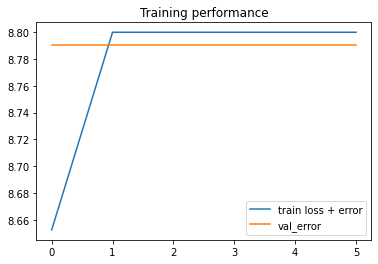

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

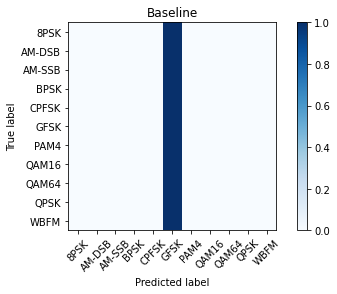

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08692421991084695


Overall Accuracy:  0.08207024029574861


Overall Accuracy:  0.08943089430894309


Overall Accuracy:  0.09416725228390724


Overall Accuracy:  0.09429190751445087


Overall Accuracy:  0.09702828499820981


Overall Accuracy:  0.08527409530634181


Overall Accuracy:  0.10138081395348837


Overall Accuracy:  0.08768193113241037


Overall Accuracy:  0.0905823148813803


Overall Accuracy:  0.0878721859114016


Overall Accuracy:  0.09231878831590336


Overall Accuracy:  0.09867172675521822


Overall Accuracy:  0.09477611940298507


Overall Accuracy:  0.0925792507204611


Overall Accuracy:  0.0918702150929639


Overall Accuracy:  0.09181784524250278


Overall Accuracy:  0.0940203083866115


Overall Accuracy:  0.0924834193072955


Overall Accuracy:  0.09462365591397849


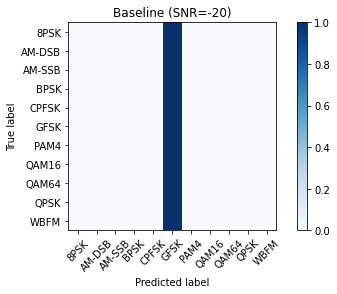

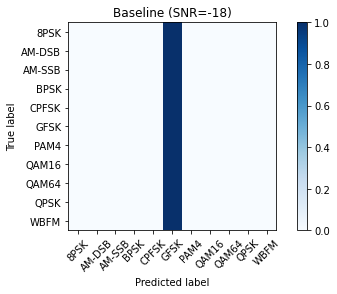

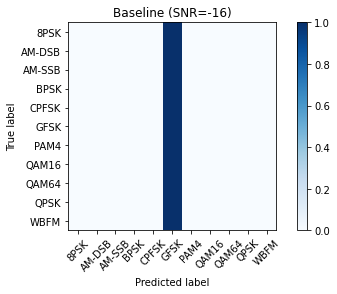

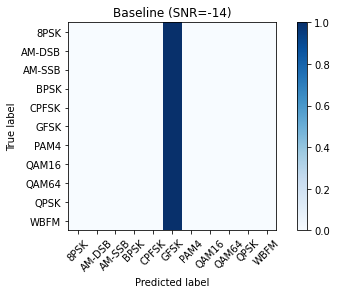

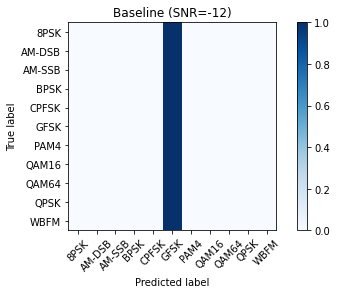

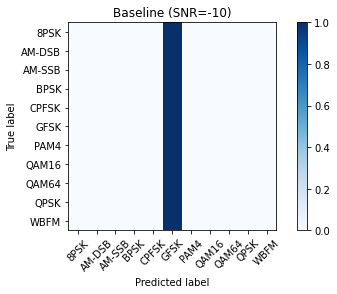

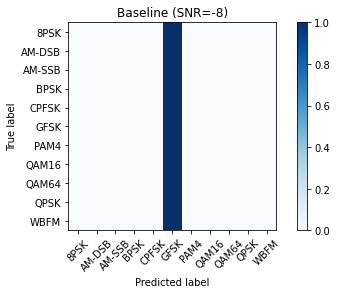

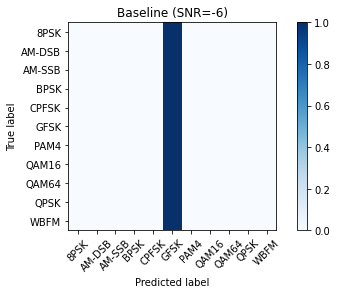

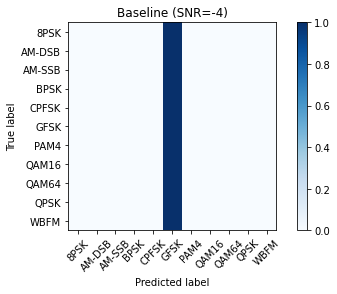

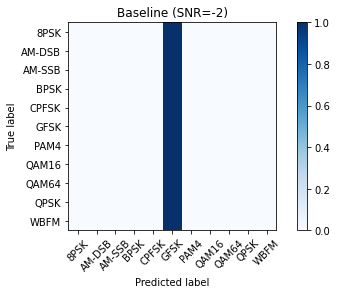

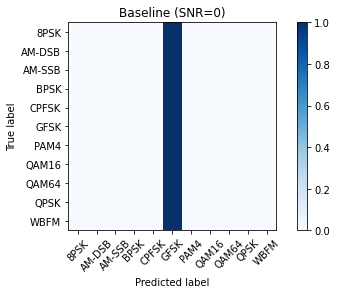

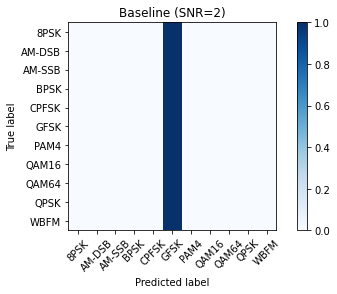

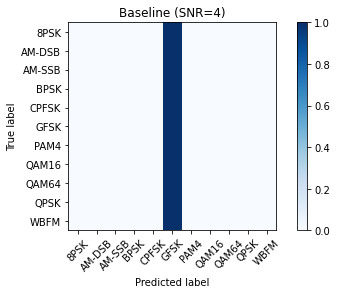

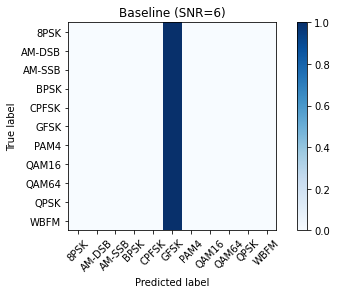

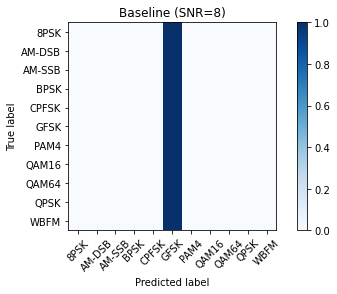

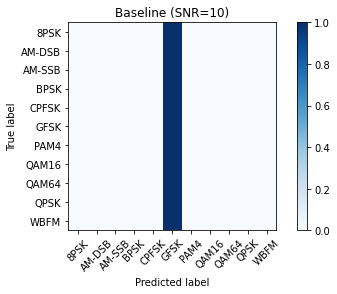

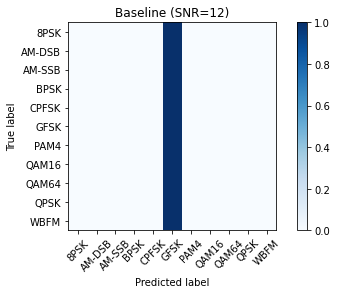

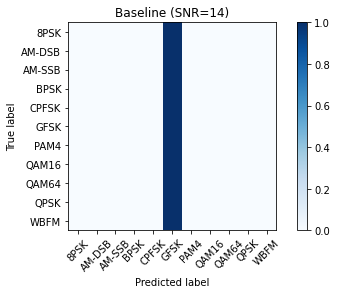

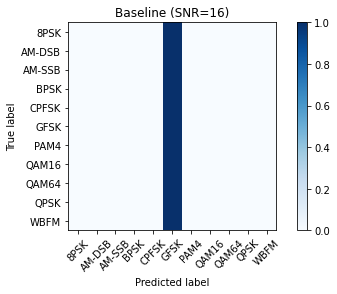

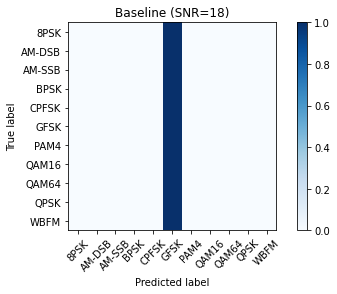

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,8,8,9,9,9,8,10,8,9,8,9,9,9,9,9,9,9,9,9


In [18]:
import statistics

statistics.mean(acc.values())

0.09199327348175244

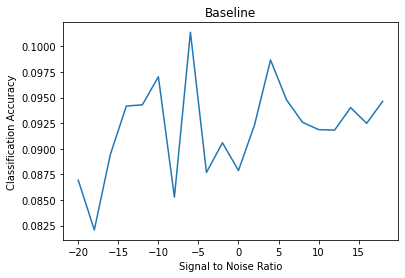

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)